# ML CUP 2022

## Support Vector Machine

This notebook creates two Support Vector Machine (SVM) models to generalize the problem of the ML cup 2022. It searches the best combination of hyperparameters performing a grid searches over a given range of values. Two different models are given as output in this phase, one for each target, and for both models there is a tuning phase based on the same hyperparameters. In the end of the notebook there is a comparison between the learning curves of KRR and SVR models.

Hyperparameters considered for the grid search:

1. kernel
2. C
3. epsilon
4. gamma (only for rbf and poly kernels)
5. degree (only for poly kernel)

Model selection performed using a cross validation.\
The model assessment phase is not included in this notebook.

### Importing libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import math

from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

import joblib

### Definition of the Mean Euclidean Distance

In [2]:
def my_mean_euclidean_distance(y_true, y_pred):
    points = len(y_true)
    tot_sum = 0
    for i in range (points):
        tot_sum += LA.norm(y_true[i] - y_pred[i])
    
    return tot_sum / points

In [3]:
mean_euclidean_distance = make_scorer(my_mean_euclidean_distance, greater_is_better=False)

### Loading data

In [4]:
colnames = ['id', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'target1', 'target2']
mlcup_tr = pd.read_csv("./dataset/ml_cup22/ML-CUP22-TR.csv", sep = ",", names=colnames)
mlcup_tr = mlcup_tr.iloc[1:, :]
mlcup_tr = mlcup_tr.drop('id', axis=1)

In [5]:
x_mlcup_tr = mlcup_tr.iloc[:, 0:9].values
y_mlcup_tr = mlcup_tr.iloc[:, 9:11].values

We used the function below to normalize our training set (both input and target) according to a min-max normalization

In [6]:
x_cols = len(x_mlcup_tr[0])

max_col_value_x = [None]*x_cols
max_vl = None

min_col_value_x = [None]*x_cols
min_vl = None

for i in range(x_cols):
    col = x_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    x_mlcup_tr[:, i] = (x_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_x[i] = max_vl
    min_col_value_x[i] = min_vl
    
    
    
y_cols = len(y_mlcup_tr[0])

max_col_value_y = [None]*y_cols

min_col_value_y = [None]*y_cols

for i in range(y_cols):
    col = y_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    y_mlcup_tr[:, i] = (y_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_y[i] = max_vl
    min_col_value_y[i] = min_vl 

We create a subset of the 30% from the training set so we can use it for the model selection. We will use these data points for the cross validation anyways.

In [7]:
subset_size = int(0.3 * len(x_mlcup_tr))

index = np.random.choice(len(x_mlcup_tr), subset_size, replace=False)
index = np.sort(index)

x_val_set = x_mlcup_tr[index]

y_val_set = y_mlcup_tr[index]

y1_val_set = y_val_set[:, 0]
y2_val_set = y_val_set[:, 1]

In [8]:
y1_mlcup_tr = y_mlcup_tr[:, 0]
y2_mlcup_tr = y_mlcup_tr[:, 1]

### Grid search for target 1
#### rbf kernel

In [9]:
C_range = np.logspace(-2, 5, 30, base = 2)
gamma_range = np.logspace(-9, 3, 10, base = 2)
epsilon_range = np.logspace(-10, 0.1, 5, base = 2)

param_grid = [
    {'gamma': gamma_range, 'C': C_range, 'epsilon': epsilon_range},
    {'gamma': ['auto', 'scale'], 'C': C_range, 'epsilon': epsilon_range}
]

grid = GridSearchCV(
    SVR(kernel = 'rbf'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4,
    n_jobs = -1
)

grid.fit(x_mlcup_tr, y1_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.5f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 1800 candidates, totalling 7200 fits
The best parameters are {'C': 0.41297831399482615, 'epsilon': 0.03235202887004304, 'gamma': 'scale'} with a score of -0.03575


In [10]:
rbf_classifier_1 = grid.best_estimator_

### linear kernel

In [11]:
C_range = np.logspace(-2, 10, 100, base = 2)
epsilon_range = np.logspace(-10, 0.1, 5, base = 2)

param_grid = dict(
    C = C_range,
    epsilon = epsilon_range
)

grid = GridSearchCV(
    SVR(kernel = 'linear'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4,
    n_jobs = -1 
)

grid.fit(x_mlcup_tr, y1_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.5f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 500 candidates, totalling 2000 fits
The best parameters are {'C': 0.6299605249474366, 'epsilon': 0.005620834296917267} with a score of -0.05338


In [12]:
linear_classifier_1 = grid.best_estimator_

### polynomial kernel

In [13]:
degree_range = np.arange(2, 5, 1)
C_range = np.logspace(-9, 5, 10, base = 2)
gamma_range = np.logspace(-9, 1, 10, base = 2)
epsilon_range = np.logspace(-10, 0.1, 5, base = 2)

param_grid = [
    {'gamma': gamma_range, 'C': C_range, 'epsilon': epsilon_range, 'degree': degree_range},
    {'gamma': ['auto', 'scale'], 'C': C_range, 'epsilon': epsilon_range, 'degree': degree_range}
]

grid = GridSearchCV(
    SVR(kernel = 'poly'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4,
    n_jobs = -1
)

grid.fit(x_mlcup_tr, y1_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.5f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 1800 candidates, totalling 7200 fits
The best parameters are {'C': 1.2599210498948736, 'degree': 2, 'epsilon': 0.03235202887004304, 'gamma': 0.9258747122872907} with a score of -0.05015


In [14]:
poly_classifier_1 = grid.best_estimator_

### Grid search for target 2
#### rbf kernel

In [15]:
C_range = np.logspace(-2, 5, 30, base = 2)
gamma_range = np.logspace(-9, 3, 30, base = 2)
epsilon_range = np.logspace(-10, 0.1, 5, base = 2)

param_grid = [
    {'gamma': gamma_range, 'C': C_range, 'epsilon': epsilon_range},
    {'gamma': ['auto', 'scale'], 'C': C_range, 'epsilon': epsilon_range}
]

grid = GridSearchCV(
    SVR(kernel = 'rbf'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4,
    n_jobs = -1
)

grid.fit(x_mlcup_tr, y2_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.5f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 4800 candidates, totalling 19200 fits
The best parameters are {'C': 0.25, 'epsilon': 0.0009765625, 'gamma': 2.5399983964682855} with a score of -0.05579


In [16]:
rbf_classifier_2 = grid.best_estimator_

#### linear kernel

In [17]:
C_range = np.logspace(-2, 10, 100, base = 2)
epsilon_range = np.logspace(-10, 0.1, 5, base = 2)

param_grid = dict(
    C = C_range,
    epsilon = epsilon_range
)

grid = GridSearchCV(
    SVR(kernel = 'linear'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4,
    n_jobs = -1
)

grid.fit(x_mlcup_tr, y2_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.5f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 500 candidates, totalling 2000 fits
The best parameters are {'C': 0.25, 'epsilon': 0.005620834296917267} with a score of -0.08217


In [18]:
linear_classifier_2 = grid.best_estimator_

#### polynomial kernel

In [19]:
degree_range = np.arange(2, 5, 1)
C_range = np.logspace(-9, 5, 10, base = 2)
gamma_range = np.logspace(-9, 1, 10, base = 2)
epsilon_range = np.logspace(-10, 0.1, 5, base = 2)

param_grid = [
    {'gamma': gamma_range, 'C': C_range, 'epsilon': epsilon_range, 'degree': degree_range},
    {'gamma': ['auto', 'scale'], 'C': C_range, 'epsilon': epsilon_range, 'degree': degree_range}
]

grid = GridSearchCV(
    SVR(kernel = 'poly'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4,
    n_jobs = -1
)

grid.fit(x_mlcup_tr, y2_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.5f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 1800 candidates, totalling 7200 fits
The best parameters are {'C': 10.886320001395017, 'degree': 2, 'epsilon': 0.005620834296917267, 'gamma': 0.19842513149602498} with a score of -0.07309


In [21]:
poly_classifier_2 = grid.best_estimator_

## Model selection
### Target 1

In [22]:
mee_1 = my_mean_euclidean_distance(y1_val_set, rbf_classifier_1.predict(x_val_set))
print("MEE score: %0.5f" %(mee_1))

MEE score: 0.03141


In [23]:
mee_1 = my_mean_euclidean_distance(y1_val_set, linear_classifier_1.predict(x_val_set))
print("MEE score: %0.5f" %(mee_1))

MEE score: 0.05360


In [24]:
mee_1 = my_mean_euclidean_distance(y1_val_set, poly_classifier_1.predict(x_val_set))
print("MEE score: %0.5f" %(mee_1))

MEE score: 0.04936


### Target 2

In [25]:
mee_2 = my_mean_euclidean_distance(y2_val_set, rbf_classifier_2.predict(x_val_set))
print("MEE score: %0.5f" %(mee_2))

MEE score: 0.04732


In [26]:
mee_2 = my_mean_euclidean_distance(y2_val_set, linear_classifier_2.predict(x_val_set))
print("MEE score: %0.5f" %(mee_2))

MEE score: 0.08202


In [27]:
mee_2 = my_mean_euclidean_distance(y2_val_set, poly_classifier_2.predict(x_val_set))
print("MEE score: %0.5f" %(mee_2))

MEE score: 0.06819


Since the best results are given by the Support Vector Machine classifier with the rbf kernel both on the first and second target, we choose these two models.

In [28]:
joblib.dump(rbf_classifier_1, './results/ml_cup/SVM/rbf_classifier_1.z')
joblib.dump(rbf_classifier_2, './results/ml_cup/SVM/rbf_classifier_2.z')

['./results/ml_cup/SVM/rbf_classifier_2.z']

### MEE on both targets on the training set

In [29]:
svr1 = joblib.load('./results/ml_cup/KRR/rbf_krr_1.z')
svr2 = joblib.load('./results/ml_cup/KRR/poly_krr_2.z')

In [30]:
pred_label_svr_1 = svr1.predict(x_mlcup_tr)
pred_label_svr_2 = svr2.predict(x_mlcup_tr)
pred_label_svr = np.vstack((pred_label_svr_1, pred_label_svr_2)).T

In [31]:
#Denormalization
def deNormalizer(pred_labels, max_col_value_y, min_col_value_y):
    
    y_cols = len(pred_labels[0])
    
    for i in range(y_cols):
        
        pred_labels[:, i] = pred_labels[:, i] * (max_col_value_y[i] - min_col_value_y[i]) + min_col_value_y[i]
    
    return pred_labels

In [32]:
pred_label_svr = deNormalizer(pred_label_svr, max_col_value_y, min_col_value_y)
y_mlcup_tr = deNormalizer(y_mlcup_tr, max_col_value_y, min_col_value_y)

In [35]:
# Mean euclidean distance
points = y_mlcup_tr.shape[0]
tot_sum = 0
for i in range (points):
    tot_sum += math.sqrt(math.pow((y_mlcup_tr[i][0] - pred_label_svr[i][0]), 2)
                         + math.pow((y_mlcup_tr[i][1] - pred_label_svr[i][1]), 2))
    
print('MEE on the training set:', tot_sum / points)

MEE on the training set: 1.335976745150474


### MEE on both targets on the validation set

In [36]:
pred_label_svr_1 = svr1.predict(x_val_set)
pred_label_svr_2 = svr2.predict(x_val_set)
pred_label_svr = np.vstack((pred_label_svr_1, pred_label_svr_2)).T

In [37]:
pred_label_svr = deNormalizer(pred_label_svr, max_col_value_y, min_col_value_y)
y_val_set = deNormalizer(y_val_set, max_col_value_y, min_col_value_y)

In [38]:
# Mean euclidean distance
points = y_val_set.shape[0]
tot_sum = 0
for i in range (points):
    tot_sum += math.sqrt(math.pow((y_val_set[i][0] - pred_label_svr[i][0]), 2)
                         + math.pow((y_val_set[i][1] - pred_label_svr[i][1]), 2))
    
print('MEE on the validation set:', tot_sum / points)

MEE on the validation set: 1.3399504823565551


### Comparison between SVM and KRR

In [39]:
from sklearn.model_selection import learning_curve

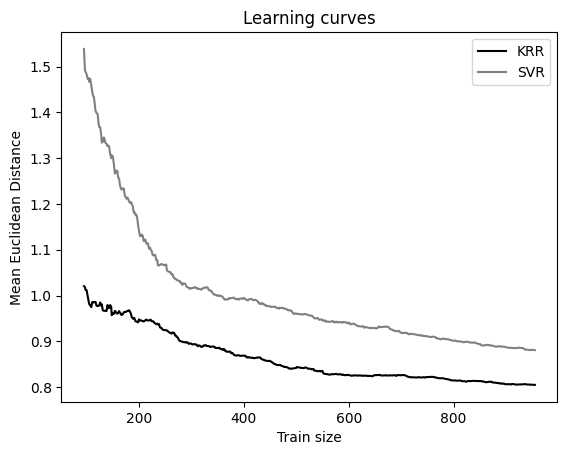

In [40]:
plt.figure()

svr = joblib.load('./results/ml_cup/SVM/rbf_classifier_1.z')
kr = joblib.load('./results/ml_cup/KRR/rbf_krr_1.z')
train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    x_mlcup_tr,
    y1_mlcup_tr,
    train_sizes = np.linspace(0.1, 1, 500),
    scoring = mean_euclidean_distance,
    cv = 5,
)
train_sizes_abs, train_scores_kr, test_scores_kr = learning_curve(
    kr,
    x_mlcup_tr,
    y1_mlcup_tr,
    train_sizes = np.linspace(0.1, 1, 500),
    scoring = mean_euclidean_distance,
    cv = 5,
)

plt.plot(train_sizes, -test_scores_kr.mean(1), color="black", label="KRR")
plt.plot(train_sizes, -test_scores_svr.mean(1), color="grey", label="SVR")
plt.xlabel("Train size")
plt.ylabel("Mean Euclidean Distance")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()

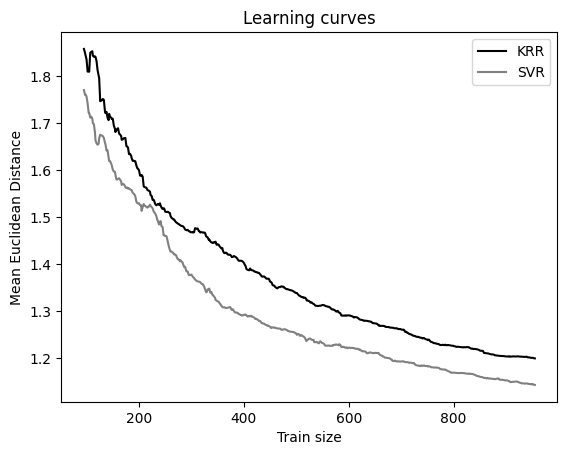

In [42]:
plt.figure()

svr = joblib.load('./results/ml_cup/SVM/rbf_classifier_2.z')
kr = joblib.load('./results/ml_cup/KRR/poly_krr_2.z')
train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    x_mlcup_tr,
    y2_mlcup_tr,
    train_sizes = np.linspace(0.1, 1, 500),
    scoring = mean_euclidean_distance,
    cv = 5,
)
train_sizes_abs, train_scores_kr, test_scores_kr = learning_curve(
    kr,
    x_mlcup_tr,
    y2_mlcup_tr,
    train_sizes = np.linspace(0.1, 1, 500),
    scoring = mean_euclidean_distance,
    cv = 5,
)

plt.plot(train_sizes, -test_scores_kr.mean(1), color="black", label="KRR")
plt.plot(train_sizes, -test_scores_svr.mean(1), color="grey", label="SVR")
plt.xlabel("Train size")
plt.ylabel("Mean Euclidean Distance")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()